# 1. Descarga y preprocesado de datos

# 1.a. Imports y settings previos

En esta sección, vamos a recopilar los imports y settings que necesitaremos más adelante y los mantendremos aquí para que sean fácilmente accesibles.

In [ ]:
#Imports y settings previos
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.models import Sequential
from sklearn.metrics import classification_report
from tensorflow.keras.layers import Dense, Flatten, Input, Conv2D
from tensorflow.keras.optimizers import SGD
import matplotlib.pyplot as plt
from google.colab import drive
from sklearn.preprocessing import LabelBinarizer
from sklearn.preprocessing import MinMaxScaler
import tensorflow as tf
from tensorflow.keras import callbacks
from tensorflow.keras import optimizers, Model
from tensorflow.keras.layers import Dropout, Flatten, Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import VGG16
from tensorflow.keras.datasets import cifar10
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from tensorflow.keras.layers import Dropout
from tensorflow.keras.constraints import max_norm
from tensorflow.keras.regularizers import l1_l2
from tensorflow.keras.layers import BatchNormalization, Activation
from tensorflow.keras.layers import GlobalMaxPooling2D, GlobalAveragePooling2D
from tensorflow.keras.layers import concatenate
import warnings
warnings.filterwarnings('ignore')

pd.set_option('display.max_rows', None) # para mostrar todas las filas
pd.set_option('display.max_columns', None) # para mostrar todas las columnas
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# 1.b. Descarga de datos

La descarga la realizamos con el codigo recogido en el siguiente colab "practica_bajado_img.ipynb" con ello obtuvimos los siguientes archivos
"filtered_data.csv" y
"images_final.npy""
Los cuales guardamos en google drive, por lo que nuestro primer paso sera descargar estos archivos desde el drive al colab.


In [ ]:

saved_data = pd.read_csv("/content/drive/MyDrive/filtered_data.csv", sep=';')
saved_img = np.load("/content/drive/MyDrive/images_final.npy")
saved_data.shape, saved_img.shape

((1593, 11), (1593, 224, 224, 3))

# 1.c. Creacion de las etiquetas

El objetivo de la practica es predecir el precio de la vivienda a partir de los datos del dataset. Para ello vamos a etiquetar los datos como baratos(aquellos los cuales tengan un precio inferior al 25% ), normales (aquellos cuyo precio este entre un 25% y un 50%) y caros(aquellos cuyo precio sea mayor que el 75%)

<Axes: >

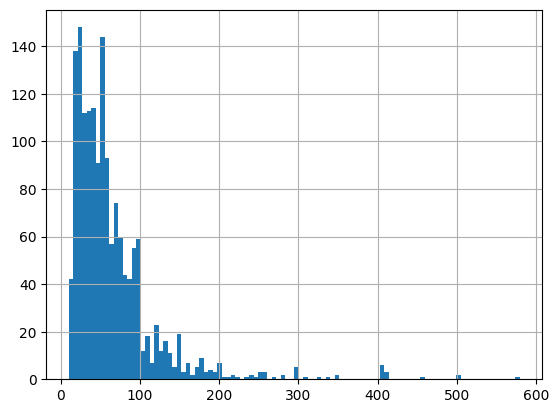

In [ ]:
saved_data['Price'].hist(bins=100)

In [ ]:
saved_data['Price'].describe()

count    1593.000000
mean       65.244821
std        57.633571
min        10.000000
25%        30.000000
50%        50.000000
75%        80.000000
max       579.000000
Name: Price, dtype: float64

<Axes: >

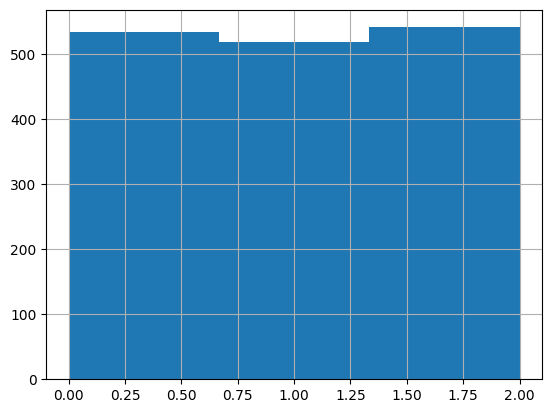

In [ ]:
# con la informacion anterior obtenemos los siguientes rangos
y_class = []
for y in saved_data['Price']:
  if y <= saved_data['Price'].quantile(0.33):
    y_class.append(0) # barato
  elif saved_data['Price'].quantile(0.33) < y <= saved_data['Price'].quantile(0.66):
    y_class.append(1) # normal
  else:
    y_class.append(2) # caro
y_class = pd.Series(y_class)
y_class.hist(bins=3)

Como se puede observar, vamos a tener más datos en las etiquetas de 'normales' que en las otras dos. Lo más académico sería tener la misma cantidad de muestras para cada etiqueta, lo cual podríamos hacer fácilmente. Sin embargo, vamos a dejarlo así porque nuestra intuición nos dice que si el modelo es capaz de detectar correctamente los precios normales, le será mucho más fácil predecir los extremos.

# 1.d. Split de datos en train/val/test

Como se observa tendremos unos datos de test 15% del total y del 75 % restante volveremos a dividir un 15% para la validacion.

In [ ]:

# dividimos datos entre entranamiento y test
data_train, data_test, img_train, img_test, y_train, y_test = train_test_split(saved_data,saved_img, y_class, test_size=0.15, shuffle=True, random_state=0)

#dividimos datos de entrenamiento entre entrenamiento y validacion
data_train, data_val, img_train, img_val, y_train, y_val = train_test_split(data_train,img_train, y_train, test_size=0.15, shuffle=True, random_state=0)


# 1.e. Normalizacion y redimensionamiento de datas numericos y categoricos



En la practica anterior de machine learing ya hicimos una exploracion del data set y elgimos las columans relevantes. Para esta practica vamos a utilizar esta informacion y nos quedaremos solo con  las columnas de
'Property Type', 'Room Type', 'Cancellation Policy', 'Bathrooms', 'Bedrooms',
'Beds','Guests Included', 'Extra People', 'Number of
Reviews'(para mas informacion de esta decision ver https://github.com/KeepCodingBDML11/machine-learning/blob/master/project/main.ipynb)

In [ ]:
# Hacemos un drop de todas las columnas que OBVIAMENTE no aportan información relevante
useful_columns = ['Property Type', 'Room Type', 'Cancellation Policy', 'Bathrooms', 'Bedrooms', 'Beds', 'Guests Included', 'Extra People', 'Number of Reviews']

data_train = data_train[useful_columns]
data_val = data_val[useful_columns]
data_test = data_test[useful_columns]


data_train.head().T

,1387,1275,137,1179,163
Property Type,Apartment,Apartment,Bed & Breakfast,Apartment,Apartment
Room Type,Entire home/apt,Entire home/apt,Private room,Private room,Entire home/apt
Cancellation Policy,strict,strict,strict,moderate,moderate
Bathrooms,1.0,1.0,2.0,1.0,1.0
Bedrooms,1.0,0.0,1.0,1.0,1.0
Beds,1.0,1.0,1.0,1.0,2.0
Guests Included,2,1,1,1,2
Extra People,12,0,0,25,5
Number of Reviews,11,1,9,1,15


Ahora pasamos a la normalizacion de los datos(copiamos de https://pyimagesearch.com/2019/01/21/regression-with-keras/). Primero normalizamos los datos continuos que corresponden a valores numericos que van aumentando progresivamente.

In [ ]:
# initialize the column names of the continuous data
continuous = ['Bathrooms', 'Bedrooms', 'Beds', 'Guests Included', 'Extra People', 'Number of Reviews']
# performin min-max scaling each continuous feature column to
# the range [0, 1]
cs = MinMaxScaler()
train_continuous = cs.fit_transform(data_train[continuous])
val_continuous = cs.fit_transform(data_val[continuous])
test_continuous = cs.fit_transform(data_test[continuous])



Ahora pasamos a one hot encoding los datos categoricos que son "Property Type" "Room Type" y "Cancellation Policy"

In [ ]:
# one-hot encode the zip code categorical data (by definition of
# one-hot encoing, all output features are now in the range [0, 1])
zipBinarizer_1 = LabelBinarizer().fit(saved_data["Property Type"])
train_categorical_1 = zipBinarizer_1.transform(data_train["Property Type"])
val_categorical_1 = zipBinarizer_1.transform(data_val["Property Type"])
test_categorical_1 = zipBinarizer_1.transform(data_test["Property Type"])


zipBinarizer_2 = LabelBinarizer().fit(saved_data["Room Type"])
train_categorical_2 = zipBinarizer_2.transform(data_train["Room Type"])
val_categorical_2 = zipBinarizer_2.transform(data_val["Room Type"])
test_categorical_2 = zipBinarizer_2.transform(data_test["Room Type"])

zipBinarizer_3 = LabelBinarizer().fit(saved_data["Cancellation Policy"])
train_categorical_3 = zipBinarizer_3.transform(data_train["Cancellation Policy"])
val_categorical_3 = zipBinarizer_3.transform(data_val["Cancellation Policy"])
test_categorical_3 = zipBinarizer_3.transform(data_test["Cancellation Policy"])




A continuacion volvemos a unir todos los datos en un solo dataframe

In [ ]:
# construct our training and testing data points by concatenating
# the categorical features with the continuous features
data_train_x = np.hstack([train_categorical_1, train_categorical_2, train_categorical_3, train_continuous])
data_val_x = np.hstack([val_categorical_1, val_categorical_2, val_categorical_3, val_continuous])
data_test_x = np.hstack([test_categorical_1, test_categorical_2, test_categorical_3, test_continuous])


Pasamos los datos de numpys a tensores(que es como lo vamos a necesitar mas tarde para poder trabajar con redes neuronales)

In [ ]:
data_train_x = tf.Variable(data_train_x)
data_val_x = tf.Variable(data_val_x)
data_test_x = tf.Variable(data_test_x)

Ahora normalizamos las etiquetas

In [ ]:

#Normalizamos las etiquetas y las ponemos en el mismo formato
#Datos a one-hot-encoding
y_train = tf.one_hot(y_train, depth=3)
y_val = tf.one_hot(y_val, depth=3)
y_test = tf.one_hot(y_test, depth=3)

#Datos en el mismo formato
y_train = tf.cast(y_train, 'float64')
y_val= tf.cast(y_val, 'float64') # o "double" si surgen problemas
y_test = tf.cast(y_test, 'float64')




Vamos a realizar un reescalado de las imagenes para hacerlas mas pequeñas con el objetivo de hacer nuestros modelos mas livianos y mas facilmente entrenables

In [ ]:
# creamos el modelo base
input_shape = (48, 48, 3)
 # resize train set
X_train_resized = []
for img in img_train:
  X_train_resized.append(np.resize(img, input_shape))

X_train_resized = tf.Variable(X_train_resized)

# resize val set
X_val_resized = []
for img in img_val:
  X_val_resized.append(np.resize(img, input_shape))

#X_val_resized = np.array(X_val_resized)
X_val_resized = tf.Variable(X_val_resized)

# resize val set
X_test_resized = []
for img in img_test:
  X_test_resized.append(np.resize(img, input_shape))

X_test_resized = tf.Variable(X_test_resized)


A continuacion realizamos un pequeno chequeo de dimensiones de las matrices ya que si esto no esta correcto es el primer fallo que daran nuestros modelos

In [ ]:
#chequeo dimensiones
print(f"Datos de entreno, Datos tabularess= {data_train_x.shape}, Datos de imagenes{img_train.shape} y {X_train_resized.shape}, Resultados={y_train.shape}")

print(f"Datos de validacion, Datos tabularess= {data_val_x.shape}, Datos de imagenes{img_val.shape} y {X_val_resized.shape}, Resultados={y_val.shape}")

print(f"Datos de test, Datos tabularess= {data_test_x.shape}, Datos de imagenes{img_test.shape} y {X_test_resized.shape}, Resultados={y_test.shape}")


Datos de entreno, Datos tabularess= (1150, 24), Datos de imagenes(1150, 224, 224, 3) y (1150, 48, 48, 3), Resultados=(1150, 3)
Datos de validacion, Datos tabularess= (204, 24), Datos de imagenes(204, 224, 224, 3) y (204, 48, 48, 3), Resultados=(204, 3)
Datos de test, Datos tabularess= (239, 24), Datos de imagenes(239, 224, 224, 3) y (239, 48, 48, 3), Resultados=(239, 3)


# 2. MODELADO

# 2.a. Modelado datos tabulares

En el siguiente modelo se han utilizado dos capas dense  relu y una ultima de salida tambien dense con salida softmax. Los resultados obtenidos son de un 70% en test lo que consideramos bastante aceptable dado los pocos datos(apenas mil) de lo que le hemos dado a la red para entrenar.
Se ha ido cambiando manualmente los hiperparametros de la red, observando una gran dependencia con el learning rate.

In [ ]:

# definimos la función para entrenar nuestra red con los parámetros deseados
def train_deep_net_1( learning_rate, lr_decay, batch_size, num_epochs):

  # Implementamos la red empleando Keras
  model = Sequential()
  model.add(Flatten())
  model.add(Dense(20, activation="relu"))
  model.add(Dense(10, activation="relu"))
  model.add(Dense(3, activation="softmax"))

  # Compilamos y entrenamos el modelo SGD
  print("[INFO]: Entrenando red neuronal...")
  lr_schedule = tf.keras.optimizers.schedules.InverseTimeDecay(
      initial_learning_rate=learning_rate,
      decay_steps=1,
      decay_rate=lr_decay
  )
  opt = tf.keras.optimizers.SGD(learning_rate=learning_rate)
  model.compile(loss="categorical_crossentropy", optimizer=opt, metrics=["accuracy"])  #(X)

  # Entrenando la solución
  H = model.fit(data_train_x, y_train, validation_data=(data_val_x, y_val), epochs=num_epochs, batch_size=batch_size)  #(X)

  # Evaluando el modelo de predicción con las imágenes de test
  print("[INFO]: Evaluando red neuronal...")
  predictions = model.predict(data_test_x, batch_size=batch_size)
  y_test_labels = np.argmax(y_test, axis=1)
  predictions_labels = np.argmax(predictions, axis=1)
  print(classification_report(y_test_labels, predictions_labels))

  # Muestro gráfica de accuracy y losses
  plt.style.use("ggplot")
  plt.figure()
  plt.plot(np.arange(0, num_epochs), H.history["loss"], label="train_loss")
  plt.plot(np.arange(0, num_epochs), H.history["val_loss"], label="val_loss")
  plt.plot(np.arange(0, num_epochs), H.history["accuracy"], label="train_acc")
  plt.plot(np.arange(0, num_epochs), H.history["val_accuracy"], label="val_acc")
  plt.title("Training Loss and Accuracy")
  plt.xlabel("Epoch #")
  plt.ylabel("Loss/Accuracy")
  plt.legend()

[INFO]: Entrenando red neuronal...
Epoch 1/30
9/9 [==============================] - 1s 15ms/step - loss: 1.1035 - accuracy: 0.3287 - val_loss: 1.0796 - val_accuracy: 0.5343
Epoch 2/30
9/9 [==============================] - 0s 2ms/step - loss: 1.0689 - accuracy: 0.4983 - val_loss: 1.0306 - val_accuracy: 0.6176
Epoch 3/30
9/9 [==============================] - 0s 2ms/step - loss: 1.0037 - accuracy: 0.5826 - val_loss: 0.9241 - val_accuracy: 0.6520
Epoch 4/30
9/9 [==============================] - 0s 2ms/step - loss: 0.9129 - accuracy: 0.6139 - val_loss: 0.8394 - val_accuracy: 0.6520
Epoch 5/30
9/9 [==============================] - 0s 2ms/step - loss: 0.8539 - accuracy: 0.6148 - val_loss: 0.7980 - val_accuracy: 0.6373
Epoch 6/30
9/9 [==============================] - 0s 2ms/step - loss: 0.8226 - accuracy: 0.6096 - val_loss: 0.7739 - val_accuracy: 0.6373
Epoch 7/30
9/9 [==============================] - 0s 2ms/step - loss: 0.8048 - accuracy: 0.6139 - val_loss: 0.7618 - val_accuracy: 0.637

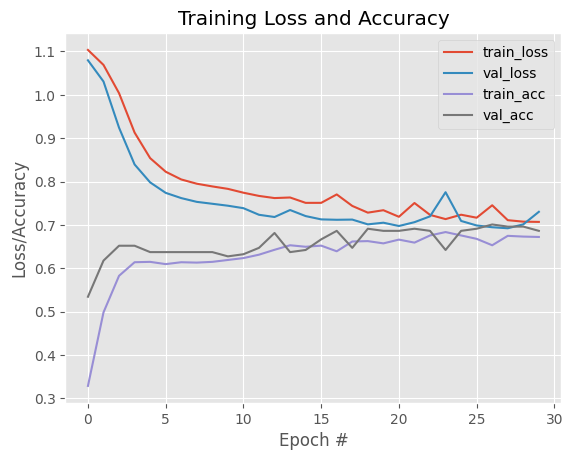

In [ ]:

learning_rate = 0.3
lr_decay = 1e-3
num_epochs = 30
batch_size = 128
train_deep_net_1( learning_rate,lr_decay, batch_size, num_epochs)

# 2.b. Modelo para imagenes con redes convolucionales preentenadas

A continuacion mostramos varios modelos donde no hemos podido conseguir que entrenara la red mas alla de ir a por la solucion mas probable, es decir nuestra red ante 3 tipos distintos de salida solo elegia 1 y asi se aseguraba el 33% de accuracy, hemos probado en el etiquetado de los datos modificar la cantidad haciendo un split de 50% 25% 25% y el comportamiento era identico siempre decia que era el split del 50% y nunca las otras dos categorias

Se han intentado diferentes hiperparametros asi como tambien hemos realizado finetuning desbloqueando diferentes capas y siempre hemos obtenido los resultados anteriores.

In [ ]:
# definimos la función para entrenar nuestra red convolucional con los parámetros deseados
def train_conv_net_1( learning_rate, lr_decay, batch_size, num_epochs):
  # creamos el modelo base
  input_shape = (224, 224, 3)
  base_model = VGG16(weights="imagenet", include_top=False, input_shape=input_shape)
  # permitimos que, además de la etapa de clasificación, se entrenen también el
  # último bloque convolucional
  for layer in base_model.layers:
    layer.trainable = False
    if layer.name == "block5_conv3":
      layer.trainable = True
  # cogemos la última capa del model y le añadimos nuestro clasificador (top_model)
  last = base_model.layers[-1].output
  x = Flatten()(last)
  x = Dense(1000, activation='relu', name='fc1')(x)
  x = Dropout(0.3)(x)
  x = Dense(3, activation='softmax', name='predictions')(x)
  model = Model(base_model.input, x)

  # compilamos el modelo
  opt = tf.keras.optimizers.SGD(learning_rate=learning_rate)
  model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])
  # entrenamos el modelo
  H = model.fit(img_train, y_train,batch_size=batch_size, validation_data=(img_val, y_val), epochs=num_epochs)
  # Evaluando el modelo de predicción con las imágenes de test
  print("[INFO]: Evaluando red neuronal...")
  predictions = model.predict(img_test, batch_size=batch_size)
  y_test_labels = np.argmax(y_test, axis=1)
  predictions_labels = np.argmax(predictions, axis=1)
  print(classification_report(y_test_labels, predictions_labels))

  # Muestro gráfica de accuracy y losses
  plt.style.use("ggplot")
  plt.figure()
  plt.plot(np.arange(0, num_epochs), H.history["loss"], label="train_loss")
  plt.plot(np.arange(0, num_epochs), H.history["val_loss"], label="val_loss")
  plt.plot(np.arange(0, num_epochs), H.history["accuracy"], label="train_acc")
  plt.plot(np.arange(0, num_epochs), H.history["val_accuracy"], label="val_acc")
  plt.title("Training Loss and Accuracy")
  plt.xlabel("Epoch #")
  plt.ylabel("Loss/Accuracy")
  plt.legend()


In [ ]:

learning_rate = 0.1
lr_decay = 1e-3
num_epochs = 5
batch_size = 128
#train_conv_net_1( learning_rate,lr_decay, batch_size, num_epochs)

NameError: ignored

In [ ]:
# definimos la función para entrenar nuestra red convolucional con los parámetros deseados
def train_conv_net_2( learning_rate, lr_decay, batch_size, num_epochs):
  # creamos el modelo base
  input_shape = (48, 48, 3)
  # resize train set
  X_train_resized = []
  for img in img_train:
   X_train_resized.append(np.resize(img, input_shape))

  X_train_resized = np.array(X_train_resized)

  # resize val set
  X_val_resized = []
  for img in img_val:
    X_val_resized.append(np.resize(img, input_shape))

  X_val_resized = np.array(X_val_resized)

  # resize val set
  X_test_resized = []
  for img in img_test:
    X_test_resized.append(np.resize(img, input_shape))

  X_test_resized = np.array(X_test_resized)

  base_model = VGG16(weights="imagenet", include_top=False, input_shape=input_shape)
  # permitimos que, además de la etapa de clasificación, se entrenen también el
  # último bloque convolucional
  for layer in base_model.layers:
    layer.trainable = False
    if layer.name == "block5_conv3":
      layer.trainable = True
  # cogemos la última capa del model y le añadimos nuestro clasificador (top_model)
  last = base_model.layers[-1].output
  x = Flatten()(last)
  x = Dense(1000, activation='relu', name='fc1')(x)
  x = Dropout(0.3)(x)
  x = Dense(3, activation='softmax', name='predictions')(x)
  model = Model(base_model.input, x)

  # compilamos el modelo
  model.compile(optimizer=Adam(learning_rate=learning_rate), loss='categorical_crossentropy', metrics=['accuracy'])
  # entrenamos el modelo
  H = model.fit( X_train_resized, y_train,batch_size=batch_size, validation_data=(X_val_resized, y_val), epochs=num_epochs)
  # Evaluando el modelo de predicción con las imágenes de test
  print("[INFO]: Evaluando red neuronal...")
  predictions = model.predict(X_test_resized, batch_size=batch_size)
  y_test_labels = np.argmax(y_test, axis=1)
  predictions_labels = np.argmax(predictions, axis=1)
  print(classification_report(y_test_labels, predictions_labels))

  # Muestro gráfica de accuracy y losses
  plt.style.use("ggplot")
  plt.figure()
  plt.plot(np.arange(0, num_epochs), H.history["loss"], label="train_loss")
  plt.plot(np.arange(0, num_epochs), H.history["val_loss"], label="val_loss")
  plt.plot(np.arange(0, num_epochs), H.history["accuracy"], label="train_acc")
  plt.plot(np.arange(0, num_epochs), H.history["val_accuracy"], label="val_acc")
  plt.title("Training Loss and Accuracy")
  plt.xlabel("Epoch #")
  plt.ylabel("Loss/Accuracy")
  plt.legend()

In [ ]:
learning_rate = 0.1
lr_decay = 1e-3
num_epochs = 15
batch_size = 128
#train_conv_net_2( learning_rate,lr_decay, batch_size, num_epochs)

In [ ]:
# definimos la función para entrenar nuestra red convolucional con los parámetros deseados
def train_conv_net_3( learning_rate, lr_decay, batch_size, num_epochs):
  # creamos el modelo base
  input_shape = (48, 48, 3)
  # resize train set
  X_train_resized = []
  for img in img_train:
   X_train_resized.append(np.resize(img, input_shape))

  X_train_resized = tf.Variable(X_train_resized)

  # resize val set
  X_val_resized = []
  for img in img_val:
    X_val_resized.append(np.resize(img, input_shape))

  #X_val_resized = np.array(X_val_resized)
  X_val_resized = tf.Variable(X_val_resized)

  # resize val set
  X_test_resized = []
  for img in img_test:
    X_test_resized.append(np.resize(img, input_shape))

  X_test_resized = tf.Variable(X_test_resized)

  base_model = VGG16(weights="imagenet", include_top=False, input_shape=input_shape)
  # permitimos que, además de la etapa de clasificación, se entrenen también el
  # último bloque convolucional
  for layer in base_model.layers:
    layer.trainable = False
    if layer.name == "block5_conv3" or layer.name == "block5_conv2" or layer.name == "block5_conv1":
      layer.trainable = True
  # cogemos la última capa del model y le añadimos nuestro clasificador (top_model)
  last = base_model.layers[-1].output
  x = Flatten()(last)
  x = Dense(1000, activation='relu', name='fc1')(x)
  x = Dropout(0.3)(x)
  x = Dense(3, activation='softmax', name='predictions')(x)
  model = Model(base_model.input, x)

  # compilamos el modelo
  model.compile(optimizer=Adam(learning_rate=learning_rate), loss='categorical_crossentropy', metrics=['accuracy'])
  # entrenamos el modelo
  H = model.fit( X_train_resized, y_train,batch_size=batch_size, validation_data=(X_val_resized, y_val), epochs=num_epochs)
  # Evaluando el modelo de predicción con las imágenes de test
  print("[INFO]: Evaluando red neuronal...")
  predictions = model.predict(X_test_resized, batch_size=batch_size)
  y_test_labels = np.argmax(y_test, axis=1)
  predictions_labels = np.argmax(predictions, axis=1)
  print(classification_report(y_test_labels, predictions_labels))

  # Muestro gráfica de accuracy y losses
  plt.style.use("ggplot")
  plt.figure()
  plt.plot(np.arange(0, num_epochs), H.history["loss"], label="train_loss")
  plt.plot(np.arange(0, num_epochs), H.history["val_loss"], label="val_loss")
  plt.plot(np.arange(0, num_epochs), H.history["accuracy"], label="train_acc")
  plt.plot(np.arange(0, num_epochs), H.history["val_accuracy"], label="val_acc")
  plt.title("Training Loss and Accuracy")
  plt.xlabel("Epoch #")
  plt.ylabel("Loss/Accuracy")
  plt.legend()

Epoch 1/15
9/9 [==============================] - 38s 4s/step - loss: 263682784.0000 - accuracy: 0.3470 - val_loss: 3169706.0000 - val_accuracy: 0.3039
Epoch 2/15
9/9 [==============================] - 37s 4s/step - loss: 1984747.5000 - accuracy: 0.3304 - val_loss: 1221325.2500 - val_accuracy: 0.3627
Epoch 3/15
9/9 [==============================] - 37s 4s/step - loss: 368285.9688 - accuracy: 0.3078 - val_loss: 525.5725 - val_accuracy: 0.3333
Epoch 4/15
9/9 [==============================] - 37s 4s/step - loss: 316.3365 - accuracy: 0.3435 - val_loss: 20.9736 - val_accuracy: 0.3333
Epoch 5/15
9/9 [==============================] - 39s 4s/step - loss: 72.0343 - accuracy: 0.3270 - val_loss: 53.8535 - val_accuracy: 0.3627
Epoch 6/15
9/9 [==============================] - 39s 4s/step - loss: 21.8118 - accuracy: 0.3409 - val_loss: 3.9780 - val_accuracy: 0.3627
Epoch 7/15
9/9 [==============================] - 39s 4s/step - loss: 1.9162 - accuracy: 0.3443 - val_loss: 1.1353 - val_accuracy: 0.

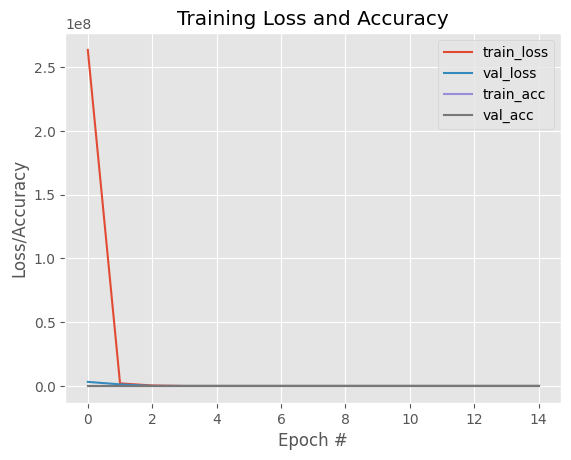

In [ ]:
learning_rate = 0.2
lr_decay = 1e-3
num_epochs = 15
batch_size = 128
train_conv_net_3( learning_rate,lr_decay, batch_size, num_epochs)

In [ ]:
learning_rate = 0.01
lr_decay = 1e-3
num_epochs = 15
batch_size = 128
#train_conv_net_3( learning_rate,lr_decay, batch_size, num_epochs)

In [ ]:
# definimos la función para entrenar nuestra red convolucional con los parámetros deseados
def train_conv_net_4( learning_rate, lr_decay, batch_size, num_epochs):
  # creamos el modelo base
  input_shape = (48, 48, 3)


  base_model = VGG16(weights="imagenet", include_top=False, input_shape=input_shape)
  # permitimos que, además de la etapa de clasificación, se entrenen también el
  # último bloque convolucional
  for layer in base_model.layers:
    layer.trainable = False
    if layer.name == "block5_conv3" or layer.name == "block5_conv2" or layer.name == "block5_conv1" or layer.name == "block4_conv3" or layer.name == "block4_conv2" or layer.name == "block4_conv1":
      layer.trainable = True
  # cogemos la última capa del model y le añadimos nuestro clasificador (top_model)
  last = base_model.layers[-1].output
  x = Flatten()(last)
  x = Dense(1000, activation='relu', name='fc1')(x)
  x = Dropout(0.3)(x)
  x = Dense(3, activation='softmax', name='predictions')(x)
  model = Model(base_model.input, x)

  # compilamos el modelo
  opt = tf.keras.optimizers.SGD(learning_rate=learning_rate)
  model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])
  # entrenamos el modelo
  H = model.fit( X_train_resized, y_train,batch_size=batch_size, validation_data=(X_val_resized, y_val), epochs=num_epochs)
  # Evaluando el modelo de predicción con las imágenes de test
  print("[INFO]: Evaluando red neuronal...")
  predictions = model.predict(X_test_resized, batch_size=batch_size)
  y_test_labels = np.argmax(y_test, axis=1)
  predictions_labels = np.argmax(predictions, axis=1)
  print(classification_report(y_test_labels, predictions_labels))

  # Muestro gráfica de accuracy y losses
  plt.style.use("ggplot")
  plt.figure()
  plt.plot(np.arange(0, num_epochs), H.history["loss"], label="train_loss")
  plt.plot(np.arange(0, num_epochs), H.history["val_loss"], label="val_loss")
  plt.plot(np.arange(0, num_epochs), H.history["accuracy"], label="train_acc")
  plt.plot(np.arange(0, num_epochs), H.history["val_accuracy"], label="val_acc")
  plt.title("Training Loss and Accuracy")
  plt.xlabel("Epoch #")
  plt.ylabel("Loss/Accuracy")
  plt.legend()

In [ ]:
learning_rate = 0.2
lr_decay = 1e-3
num_epochs = 10
batch_size = 128
#train_conv_net_4( learning_rate,lr_decay, batch_size, num_epochs)

Epoch 1/10
9/9 [==============================] - 64s 7s/step - loss: nan - accuracy: 0.3009 - val_loss: nan - val_accuracy: 0.3627
Epoch 2/10
9/9 [==============================] - 65s 7s/step - loss: nan - accuracy: 0.3226 - val_loss: nan - val_accuracy: 0.3627
Epoch 3/10
2/9 [=====>........................] - ETA: 49s - loss: nan - accuracy: 0.3047

KeyboardInterrupt: ignored

# 2.c. Modelo para imagenes conredes convolucionales

Mismos resultados y conclusiones que con el punto 2.b

In [ ]:
# definimos la función para entrenar nuestra red con los parámetros deseados
def train_conv_net_5( learning_rate, lr_decay, batch_size, num_epochs):

  # Implementamos la red empleando Keras
  # Inizializamos el modelo
  model = Sequential()

  # Probabilidad de dropout (probabilidad que un peso w = 0 en entrenamiento)
  P = 0.25

  # Definimos una capa convolucional
  model.add(Conv2D(128, kernel_size=(3, 3), activation='relu', input_shape=(48, 48, 3)))
  model.add(Dropout(P))

  # Definimos una segunda capa convolucional
  model.add(Conv2D(128, kernel_size=(3, 3), activation='relu'))
  model.add(Dropout(P))

  # Definimos una tercera capa convolucional
  model.add(Conv2D(128, kernel_size=(3, 3), activation='relu'))
  model.add(Dropout(P))

  # Añadimos nuestro clasificador
  model.add(Flatten())
  model.add(Dense(1024, activation='relu'))
  model.add(Dropout(P))
  model.add(Dense(3, activation='softmax'))


  # Compilamos y entrenamos el modelo SGD
  print("[INFO]: Entrenando red neuronal...")
  lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=0.01,
    decay_steps=100,
    decay_rate=0.96,
    staircase=True
  )
  model.compile(loss='categorical_crossentropy',
              optimizer=Adam(learning_rate=lr_schedule),
              metrics=['accuracy'])


  # entrenamos el modelo
  H = model.fit( X_train_resized, y_train,batch_size=batch_size, validation_data=(X_val_resized, y_val), epochs=num_epochs)
  # Evaluando el modelo de predicción con las imágenes de test
  print("[INFO]: Evaluando red neuronal...")
  predictions = model.predict(X_test_resized, batch_size=batch_size)
  y_test_labels = np.argmax(y_test, axis=1)
  predictions_labels = np.argmax(predictions, axis=1)
  print(classification_report(y_test_labels, predictions_labels))


  # Muestro gráfica de accuracy y losses
  plt.style.use("ggplot")
  plt.figure()
  plt.plot(np.arange(0, num_epochs), H.history["loss"], label="train_loss")
  plt.plot(np.arange(0, num_epochs), H.history["val_loss"], label="val_loss")
  plt.plot(np.arange(0, num_epochs), H.history["accuracy"], label="train_acc")
  plt.plot(np.arange(0, num_epochs), H.history["val_accuracy"], label="val_acc")
  plt.title("Training Loss and Accuracy")
  plt.xlabel("Epoch #")
  plt.ylabel("Loss/Accuracy")
  plt.legend()

[INFO]: Entrenando red neuronal...
Epoch 1/15
9/9 [==============================] - 139s 15s/step - loss: 413.2640 - accuracy: 0.3678 - val_loss: 1.1003 - val_accuracy: 0.3627
Epoch 2/15
9/9 [==============================] - 130s 15s/step - loss: 1.1090 - accuracy: 0.3270 - val_loss: 1.1002 - val_accuracy: 0.3333
Epoch 3/15
9/9 [==============================] - 129s 14s/step - loss: 1.1025 - accuracy: 0.3400 - val_loss: 1.1034 - val_accuracy: 0.3333
Epoch 4/15
9/9 [==============================] - 129s 14s/step - loss: 1.1014 - accuracy: 0.3226 - val_loss: 1.0977 - val_accuracy: 0.3627
Epoch 5/15
9/9 [==============================] - 129s 14s/step - loss: 1.0999 - accuracy: 0.3191 - val_loss: 1.1022 - val_accuracy: 0.3039
Epoch 6/15
9/9 [==============================] - 129s 14s/step - loss: 1.0990 - accuracy: 0.3409 - val_loss: 1.1005 - val_accuracy: 0.3333
Epoch 7/15
9/9 [==============================] - 137s 15s/step - loss: 1.0993 - accuracy: 0.3461 - val_loss: 1.0998 - val_

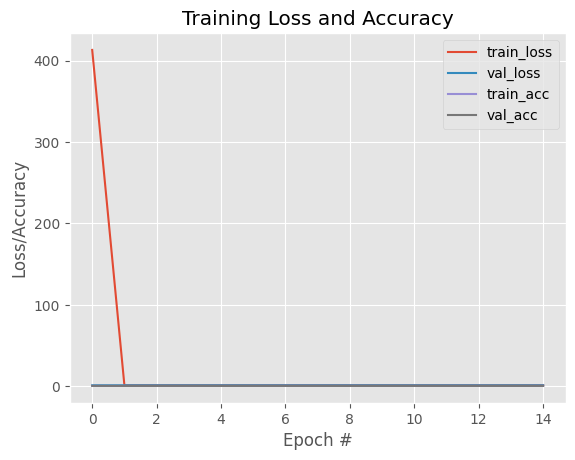

In [ ]:
learning_rate = 0.01
lr_decay = 1e-3
num_epochs = 15
batch_size = 128
train_conv_net_5( learning_rate,lr_decay, batch_size, num_epochs)

In [ ]:
# definimos la función para entrenar nuestra red con los parámetros deseados
def train_conv_net_6( learning_rate, lr_decay, batch_size, num_epochs):

  # Implementamos la red empleando Keras
  # Inizializamos el modelo
  model = Sequential()

  # Probabilidad de dropout (probabilidad que un peso w = 0 en entrenamiento)
  P = 0.25

  # Definimos una capa convolucional
  model.add(Conv2D(128, kernel_size=(3, 3), activation='relu', input_shape=(48, 48, 3)))
  model.add(Dropout(P))

  # Definimos una segunda capa convolucional
  model.add(Conv2D(128, kernel_size=(3, 3), activation='relu'))
  model.add(Dropout(P))

  # Definimos una tercera capa convolucional
  model.add(Conv2D(128, kernel_size=(3, 3), activation='relu'))
  model.add(Dropout(P))

  # Añadimos nuestro clasificador
  model.add(Flatten())
  model.add(Dense(1024, activation='relu'))
  model.add(Dropout(P))
  model.add(Dense(3, activation='softmax'))


  # Compilamos y entrenamos el modelo SGD
  print("[INFO]: Entrenando red neuronal...")
  opt = tf.keras.optimizers.SGD(learning_rate=learning_rate)
  model.compile(loss='categorical_crossentropy',
              optimizer=opt,
              metrics=['accuracy'])


  # entrenamos el modelo
  H = model.fit( X_train_resized, y_train,batch_size=batch_size, validation_data=(X_val_resized, y_val), epochs=num_epochs)
  # Evaluando el modelo de predicción con las imágenes de test
  print("[INFO]: Evaluando red neuronal...")
  predictions = model.predict(X_test_resized, batch_size=batch_size)
  y_test_labels = np.argmax(y_test, axis=1)
  predictions_labels = np.argmax(predictions, axis=1)
  print(classification_report(y_test_labels, predictions_labels))


  # Muestro gráfica de accuracy y losses
  plt.style.use("ggplot")
  plt.figure()
  plt.plot(np.arange(0, num_epochs), H.history["loss"], label="train_loss")
  plt.plot(np.arange(0, num_epochs), H.history["val_loss"], label="val_loss")
  plt.plot(np.arange(0, num_epochs), H.history["accuracy"], label="train_acc")
  plt.plot(np.arange(0, num_epochs), H.history["val_accuracy"], label="val_acc")
  plt.title("Training Loss and Accuracy")
  plt.xlabel("Epoch #")
  plt.ylabel("Loss/Accuracy")
  plt.legend()

In [ ]:
learning_rate = 0.2
lr_decay = 1e-3
num_epochs = 15
batch_size = 128
train_conv_net_6( learning_rate,lr_decay, batch_size, num_epochs)

[INFO]: Entrenando red neuronal...
Epoch 1/15
9/9 [==============================] - 125s 14s/step - loss: 61541898518528.0000 - accuracy: 0.3383 - val_loss: nan - val_accuracy: 0.3676
Epoch 2/15
9/9 [==============================] - 123s 14s/step - loss: nan - accuracy: 0.3226 - val_loss: nan - val_accuracy: 0.3627
Epoch 3/15


KeyboardInterrupt: ignored

# 3. Fusion de modelos

A continuacion la union de los modelos, los resultados son algo peores que con los datos tabulares solo, pero teniendo en cuenta lo mal que nos fue en el modelo de tratamiento de imagenes lo consideramos como aceptable. Seguramente la union de los dos modelos que hemos realizado ignore los resultados de la red de las imagenes ya que despues de la union de los dos modelos hemos puesto mas capas.

In [ ]:
# definimos la función para entrenar nuestra red con los parámetros deseados
def train_mix( learning_rate, lr_decay, batch_size, num_epochs):

  # Inizializamos el modelo para imagenes
  inputA = Input(shape=(48,48,3))
  model_A = Conv2D(128, kernel_size=(3, 3), activation='relu')(inputA)

  # Definimos una segunda capa convolucional
  model_A = Conv2D(128, kernel_size=(3, 3), activation='relu')(model_A)

  # Definimos una tercera capa convolucional
  model_A = Conv2D(128, kernel_size=(3, 3), activation='relu')(model_A)

  # Añadimos nuestro clasificador
  model_A = Flatten()(model_A)
  model_A = Dense(64, activation='relu')(model_A)
  model_A = Dense(32, activation='relu')(model_A)
  model_A = Model(inputs=inputA, outputs=model_A)




  # IInizializamos modelo para datos tabulares
  inputB = Input(shape=(24,))
  model_B = Flatten()(inputB)
  model_B = Dense(20, activation="relu")(model_B)
  model_B = Dense(10, activation="relu")(model_B)
  model_B = Model(inputs=inputB, outputs=model_B)

  # Unimos
  combined = concatenate([model_A.output, model_B.output])
  #Y añadimos mas capas antes de dar la prediccion
  # apply a FC layer and then a regression prediction on the
  # combined outputs
  z = Dense(21, activation="relu")(combined)
  z = Dense(7, activation="relu")(combined)
  z = Dense(3, activation="softmax")(z)
  # our model will accept the inputs of the two branches and
  # then output a single value
  model = Model(inputs=[model_A.input, model_B.input], outputs=z)



  # Compilamos y entrenamos el modelo SGD
  print("[INFO]: Entrenando red neuronal...")
  opt = tf.keras.optimizers.SGD(learning_rate=learning_rate)
  model.compile(loss='categorical_crossentropy', optimizer=opt,metrics=['accuracy'])


  # entrenamos el modelo
  H = model.fit( [X_train_resized,data_train_x], y_train, batch_size=batch_size, validation_data=([X_val_resized,data_val_x], y_val), epochs=num_epochs)
  # Evaluando el modelo de predicción con las imágenes de test
  print("[INFO]: Evaluando red neuronal...")
  predictions = model.predict([X_test_resized,data_test_x], batch_size=batch_size)
  y_test_labels = np.argmax(y_test, axis=1)
  predictions_labels = np.argmax(predictions, axis=1)
  print(classification_report(y_test_labels, predictions_labels))


  # Muestro gráfica de accuracy y losses
  plt.style.use("ggplot")
  plt.figure()
  plt.plot(np.arange(0, num_epochs), H.history["loss"], label="train_loss")
  plt.plot(np.arange(0, num_epochs), H.history["val_loss"], label="val_loss")
  plt.plot(np.arange(0, num_epochs), H.history["accuracy"], label="train_acc")
  plt.plot(np.arange(0, num_epochs), H.history["val_accuracy"], label="val_acc")
  plt.title("Training Loss and Accuracy")
  plt.xlabel("Epoch #")
  plt.ylabel("Loss/Accuracy")
  plt.legend()

[INFO]: Entrenando red neuronal...
Epoch 1/20
9/9 [==============================] - 65s 7s/step - loss: 1.0900 - accuracy: 0.4522 - val_loss: 1.0447 - val_accuracy: 0.5049
Epoch 2/20
9/9 [==============================] - 63s 7s/step - loss: 1.0225 - accuracy: 0.5113 - val_loss: 0.9685 - val_accuracy: 0.5588
Epoch 3/20
9/9 [==============================] - 63s 7s/step - loss: 0.9435 - accuracy: 0.5348 - val_loss: 0.8810 - val_accuracy: 0.5490
Epoch 4/20
9/9 [==============================] - 64s 7s/step - loss: 0.8754 - accuracy: 0.5609 - val_loss: 0.8331 - val_accuracy: 0.5490
Epoch 5/20
9/9 [==============================] - 64s 7s/step - loss: 0.8418 - accuracy: 0.5913 - val_loss: 0.8044 - val_accuracy: 0.6422
Epoch 6/20
9/9 [==============================] - 65s 7s/step - loss: 0.8203 - accuracy: 0.6235 - val_loss: 0.7878 - val_accuracy: 0.6275
Epoch 7/20
9/9 [==============================] - 63s 7s/step - loss: 0.8064 - accuracy: 0.6061 - val_loss: 0.7793 - val_accuracy: 0.6422

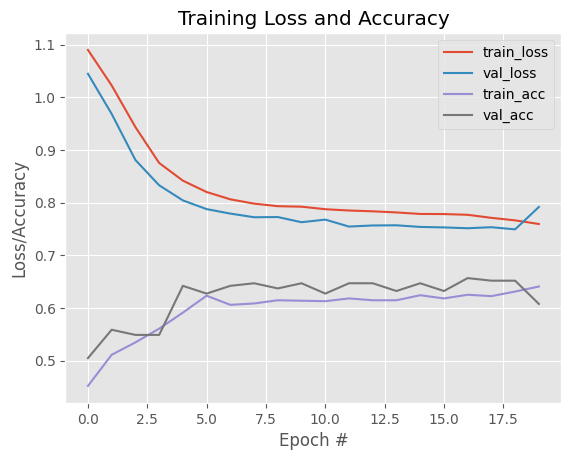

In [ ]:
learning_rate = 0.2
lr_decay = 1e-3
num_epochs = 20
batch_size = 128
train_mix( learning_rate,lr_decay, batch_size, num_epochs)